# The Rainbow Method Part I. Encoding Categorical Variables. 
> 'When the nature gives you a rainbow, take it.'

- author: Anna Arakelyan, Dmytro Karabash
- categories: [python, data science, classification, encoding]
- image: ../images/jd-rincs-9GkYmKYVoGY-unsplash.jpg
- permalink: /rainbow/
- hide: true

![rainbow](../images/jd-rincs-9GkYmKYVoGY-unsplash.jpg)

## Introduction

"I have 2000 features and I need to get to 50 features and keep model as good or better" was how this all started.  This is familiar to anyone in institutional data science where you need to carefully vet every model and look at each feature to make sure it is fine from the standpoint of regulation.  What is valuable about this story is that it is based on a real production model that was developed by Anna Arakelyan at MassMutual and a method suggested by Dmytro Karabash.  We will get to detailed results at the end but here's a preview results for anyone who want to take a peak:

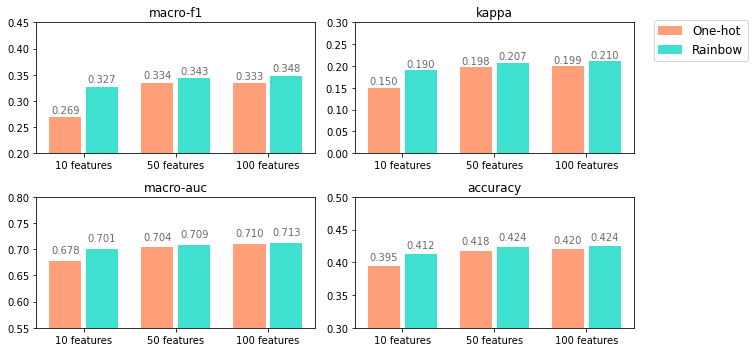

In [1]:
#hide_input

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings("ignore")
# Add 'rainbow_research.csv' and 'rainbow_research_feature_selection.csv' in the _notebooks folder
# Don't push data to repo - they must be ignored in .gitignore
results = pd.read_csv('rainbow_research.csv').rename(columns={'feature_selection_parameter':'Num_features',"transform_parameter": "method"})
feature_selection = pd.read_csv('rainbow_research_feature_selection.csv').rename(columns={'feature_selection_parameter':'Num_features',"transform_parameter": "method"})

results['method']=results['method'].replace({'one_hot': "One-hot", 'rainbow': "Rainbow"})

metrics=['accuracy', 'kappa', 'macro avg_f1-score', 'weighted avg_f1-score', 'macro avg_roc_auc', 'weighted avg_roc_auc']
tmp = feature_selection.groupby(['Num_features', 'method'])[metrics].mean().round(4).reset_index()

tmp['Num_features']=tmp['Num_features'].str.replace('top_',"").astype(int)
table1 = tmp.set_index(['Num_features', 'method']).sort_index()

table1=table1.rename(columns={'macro avg_f1-score': 'macro-f1',
                       'weighted avg_f1-score':'weighted-f1',
                       'macro avg_roc_auc':'macro-auc',
                       'weighted avg_roc_auc' : 'weighted-auc'
                      })
# table1[['macro-f1','accuracy','kappa','macro-auc']].round(2)
table11 = table1[['macro-f1','accuracy','kappa','macro-auc']].round(4).reset_index()


def autolabel(rects, i, j, decimals=3):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        axs[i, j].text(rect.get_x() + rect.get_width()/2., 1.015*height,
                '%.{}f'.format(decimals) % height,
                ha='center', va='bottom', color = 'dimgrey')  

def make_subplot(table11, metric, x, i, j, colors, ylimits=[]):
    y1 = table11[table11['method']=='one_hot'][metric]
    y2 = table11[table11['method']=='rainbow'][metric]
    rects1 = axs[i, j].bar(x-0.2, y1, width, label = 'One-hot', color = colors[0])
    rects2 = axs[i, j].bar(x+0.2, y2, width, label = 'Rainbow', color = colors[1]) 
    axs[i, j].set_ylim(ylimits)
    axs[i, j].set_xticks(x)    
    axs[i, j].set_xticklabels(['10 features', '50 features', '100 features'], rotation=0)
    axs[i, j].set_title(metric)
    autolabel(rects1, i, j)
    autolabel(rects2, i, j)
    
x = np.arange(3)
fig, axs = plt.subplots(2, 2, figsize=(9,5))
width = 0.35
colors = ['lightsalmon', 'turquoise']
make_subplot(table11, 'macro-f1', x, 0, 0, colors, [0.2,0.45])
make_subplot(table11, 'kappa', x, 0, 1, colors, [0, 0.30])
make_subplot(table11, 'macro-auc', x, 1, 0, colors, [0.55, 0.80])
make_subplot(table11, 'accuracy', x, 1, 1, colors, [0.3, 0.50])
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 2.4), loc='upper left', prop={'size': 12})
plt.show()

The rainbow method outperforms the One-hot easily. In fact, the rainbow method even shows better result for 50 features than One-hot does for 100. Also note that when droping from 50 to 10 features, the reduction in macro-f1 if you use One-hot is 6 times that of the rainbow method (3 times for kappa and accuracy, 2 times for macro-auc).

>Both models actually keep improving as the number of features goes up. Though the improvement is substantially faster and bigger for the rainbow method.

## Background

Data encoding is the crucial part of any data science pipeline. No matter which machine learning algorithm is used - there is no avoiding of data cleaning and encoding. Especially with dirty and complex real data sets, ensuring the most appropriate and efficient way of feature encoding and engineering is a nontrivial problem. While encoding quantitative and binary columns is usually a straightforward task, the encoding of categorical variables deserves a deeper look. 
<br><br>
One of the most popular encoding methods for categorical variables has been the One-hot procedure. It generates an indicator variable for every category and, thus, creates a set of K new features, where K is the number of categories.
One significant implication of this method is the dimensionality increase. Depending on the magnitude of K, it can have various undesirable technical consequences: substantial raise of computational complexity, loss of degrees of freedom (N-K, where N is the number of samples), multicollinearity, and, ultimately, an overfitted model. Non-technical consequences include unnecessary complication of the model that should be communicated to final users and that contradict the law of parsimony aka Occam's razor.

## Method

We call it rainbow from a very simple analogy: if you have a categorical feature with names "Red", "Orange", "Yellow", "Green", "Blue", "Indigo" and "Violet", in other words - colors of the rainbow, instead of one hot encoding, you can simply create one feature with encoding:
***
0 = "Red" <br>
1 = "Orange" <br>
2 = "Yellow" <br>
3 = "Green" <br>
4 = "Blue" <br>
5 = "Indigo" <br>
6 = "Violet"

This would replace seven One-hot features with one rainbow.  

Most of the nominal variables, from the first glance, seem like they cannot be converted to a quantitative scale. This is where we suggest **finding a rainbow**.
<br>
The seemingly unordered categories acquire a perfect order if we find a scale, where each category fits into its own unique place. With the color - the natural scale is Hue. But it is not the only one. We can think of, say, brightness, saturation, color temperature, etc. We invite you to experiment with a few different rainbows that might capture different nuances of the categorical quality. 

You can actually make and use two or more rainbows out of one categorical variable depending on the number of categories K and the context.

> We don't recommend to use much more than $\log_2 {K}$. The reason we suggest not to use more than $\log_2 K$ rainbows is not to surpass a number of encodings in what is called binary-One-hot-encoding.  One easy way to create $\log_2 K$ out of any rainbow is by rotating binary digits of your first rainbow; note rotating not permuting as if you would permute you would get $(\log_2 K)!$ which is greater than K for K>8.


Why is rainbow better than any other choice? It is very simple and intuitively sensible. In many cases it is not even that important which rainbow you choose (and by that we mean the color order), it would still be better than using One-hot. The more natural orders are just likely to be slightly better than others and easier to remember. 

> Hence our motto: "When a nature gives you a rainbow, take it..."


Important note here: this method is highly efficient in conjunction with the models that rely on variables as ranks rather than exact values. For example, decision trees, random forest, gradient boosting - these algorithms will output the same result if, say, the variable *Number of Children* is coded as 
***
0 = "0 Children" <br>
1 = "1 Child"<br>
2 = "2 Children"<br>
3 = "3 Children"<br>
4 = "4 or more Children" 

or as 
***
1 = "0 Children" <br>
2 = "1 Child"<br>
3 = "2 Children"<br>
4 = "3 Children"<br>
5 = "4 or more Children" 


or even as 

***
-100 = "0 Children" <br>
-85 = "1 Child"<br>
0 = "2 Children"<br>
10 = "3 Children"<br>
44 = "4 or more Children" 


as long as the correct order of the categories is preserved. The values themselves don't carry the quantitative role in these algorithms. It is the rank of the variable that matters, and a tree-based algorithm will use its 
magic to make the most appropriate splits to introduce new tree nodes.

The application of our method for other algorithms such as Linear Regression, Logistic Regression is out of scope of this article. We expect that such way of feature engineering would be still beneficial, but that is a subject of a different investigation.

Note that by using a rainbow rather than One-hot we are not losing any of the signal. Let's consider two scenarios. First, if the categories are wildly different, and each one introduces a substantial gain to the model, the algorithm such as *xgboost* will just make the splits between all the values which is perfectly equivalent to One-hot. Second, if the chosen rainbow order is the least favorable, once again, the algorithm will make all the necessary splits.
However, if the rainbow order is even somewhat meaningful, the algorithm would capture the similarity in the adjacent values by making a smart decision about the number and location of splits. For example, it will decide if some of the adjacent values should be clustered together, or separated. This will save us dimensionality without any informational loss.

## Examples

The application of our method depends highly on the level of measurement of the treated variables. While **quantitative** variables have a *ratio* scale, i.e. they have a meaningful 0, ordered values, and equal distances between values; **categorical** variables usually have either *interval*, or *ordinal*, or *nominal* scales.
Let us illustrate our method for each of these types of categorical variables.

**Interval** variables have ordered values, equal distances between values, but the value itself is not necessarily meaningful, for example, 0 does not indicate an absence of a quality. The common examples of interval variables are Likert scales:
<br>
***
*How likely is the person to buy a smartphone mobile phone?*
<br><br>
1 = "Very Unlikely" <br>
2 = "Somewhat Unlikely"<br>
3 = "Neither Likely, Nor Unlikely"<br>
4 = "Somewhat Likely"<br>
5 = "Very Likely"

In a straightforward way, if we simply use the raw values 1 through 5, that will save us dimensionality without losing a single bit of information. The algorithm such as *xgboost* will make the appropriate splits instead of being forced to use the splits predetermined by One-hot, which in many cases is simply an overfit.

**Ordinal** variables have ordered values that are meaningless, and the distances between values are also not equal or not even explainable. An example: <br>
***
*What is the highest level of Education completed by the person?*
<br><br>
1 = "No High School"<br>
2 = "High School" <br>
3 = "Associate Degree" <br>
4 = "Bachelor's Degree" <br>
5 = "Master's Degree" <br>
6 = "Doctoral Degree" <br>

Similar to interval variables, raw ordinal numeric codes can be used in the model without introducing any issues, as long as the order is correct. In some cases, a variable is intrinsically ordinal, but the given numeric codes don't follow the correct order - in these situations we could simply reorder categories and then use this updated variable as a quantitative feature.

The use of natural rainbow for interval and ordinal variables is likely not the cause for concern because it is clearly a perfect alternative to One-hot for tree-based algorithms. The more complicated and non-obvious question is how to treat nominal variables.

**Nominal** variables have no obvious order between categories, and are almost always encoded with One-hot method. This is where finding a rainbow becomes valuable, turning something, that seems completely non quantitative, into a quantitative scale. In this way, a nominal variable *Color* 
***
A = "Red" <br>
B = "Blue" <br>
C = "Green" <br>
D = "Yellow" <br>

is replaced by the newly engineered rainbow feature

***
1 = "Blue" <br>
2 = "Green"<br>
3 = "Yellow"<br>
4 = "Red"<br>

Lets us show a few other examples of creating rainbows.

***
*Vehicle Type* <br><br>
C = "Compact Car"<br>
F = "Full-size Car"<br>
L = "Luxury Car"<br>
M = "Mid-Size Car"<br>
P = "Pickup Truck"<br>
S = "Sports Car"<br>
U = "SUV"<br>
V = "Van"<br>

For this variable we can think of dozens of characteristics to make a rainbow - vehicle size, capacity, price category, average speed, fuel economy, costs of ownership, motor features, etc. Which one (or more than one) to pick? The choice depends on the context of the model and what are you trying to predict. The preference should be given to the ones that provide more explanatory power and/or make sense from the interpretation standpoint.

Consider another variable:

***
*Marital Status* <br><br>
A = "Married" <br>
B = "Single" <br>
C = "Inferred Married" <br>
D = "Inferred Single" <br>

If we think about Single and Married as the two ends of the spectrum, then Inferred Single could be between the two ends, closer to Single, while Inferred Married would be between the two ends, closer to Married. That would make sense because Inferred holds certain degree of uncertainty. Thus, the following order would be reasonable:
***
1 = "Single" <br>
2 = "Inferred Single" <br>
3 = "Inferred Married" <br>
4 = "Married"

In case there are any missing values here, the Unknown category fits exactly in the middle between Single and Married as there is no reason to prefer one end over the other. So the modified scale could look like this:
***
1 = "Single" <br>
2 = "Inferred Single" <br>
3 = "Unknown" <br>
3 = "Inferred Married" <br>
4 = "Married"

Another example:
***
*Occupation* <br><br>
1 = "Professional/Technical"<br>
2 = "Administration/Managerial"<br>
3 = "Sales/Service"<br>
4 = "Clerical/White Collar"<br>
5 = "Craftsman/Blue Collar"<br>
6 = "Student"<br>
7 = "Homemaker"<br>
8 = "Retired"<br>
9 = "Farmer"<br>
A = "Military"<br>
B = "Religious"<br>
C = "Self Employed"<br>
D = "Other"<br>

Finding a rainbow here might be harder, but here are a few ways to do it: we could order occupations by average annual salary, by its prevalence in the geographic area of interest, or by information from some other dataset. That might involve calling a Census API or some other data source, and might be complicated by the fact that these values are not static, but these are still viable solutions.

## What if there is no natural rainbow?

In some situations though we cannot find a logical order for the rainbow because the variable itself is not interpretable. An example could be a black box column made by a third party:
***
*Financial Cluster of the Household* <br><br>
1 = "Market Watchers" <br>
2 = "Conservative Wealth" <br>
3 = "Specific Savers" <br>
4 = "Tried and True" <br>
5 = "Trendy Inclinations" <br>
6 = "Current Consumers" <br>
7 = "Rural Trust" <br>
8 = "City Spotlight" <br>
9 = "Career Conscious" <br>
10 = "Digital Financiers" <br>
11 = "Financial Futures" <br>
12 = "Stable Influentials" <br>
13 = "Conservatively Rural"

In this case we might not have a clear idea how to order categories due to lack of knowledge of what each category entails. What to do with such variables?

We recommend creating an artificial rainbow by looking at how each category is related to the target variable. 

The simplest solution is to place categories in the order of correlation with target variable. 
So the category with the highest value of correlation with the dependent variable would acquire numeric code 1, and the category with the lowest correlation would acquire numeric code 13. So our rainbow in this case would mean the relationship between the cluster and the target variable. This method would work for both - classification and regression models - as it can be applied to discrete and to continuous target variable.

Alternatively, you can construct your own rainbows by merely utilizing certain statistical qualities of the categorical variable and the target variable.

For instance, in case of a binary target variable, and we could look at the proportion of ones given each of the categories. Suppose, among Market Watchers percent of positive targets is 0.67, while for Conservative Wealth it is 0.45. In that case, Market Watchers will be ordered higher than Conservative Wealth (or lower, if the target percent scale is ascending). In other words, this rainbow would reflect the prevalence of positive target inside each category. 

In case of multiclass classification, we could create rainbows for each class to represent relationship between categories and each class separately.

In Part I, we introduced you to the Rainbow method. In Part II we provide an empirical example of its application 
and demonstrate its superiority over One-hot using the real data project developed at MassMutual. In Part III, we provide theoretical justification for the method.

# The Rainbow Method Part II. Application to a Real Data Science Problem

We will illustrate the effectiveness of the rainbow encoding method using the real data science project developed in the Customer Journey domain of [Data Science at MassMutual](datascience.massmutual.com) - a life insurance company with a 170 years of history which takes pride in growing a large team of data scientists, engineers, and technologists to support most of the business decisions.

## Business Use Case

In a nutshell, the data task is a multiclass classification problem that aims to predict one of the five Mindset Segments for each of the prospective customers. 

<img src="img-anna/seg_framework.png" width="600">

The segmentation framework represents five classes that reflect a person's age, financial stability, and attitude towards financial decisions. The predicted segments are then used by MassMutual marketing team in different types of campaigns for targeting and customization. For example, Self-Assured customers would value more independence and autonomy in making decision of buying a life insurance policy whereas Day to Day customers would value having a guidance and thorough explanations of different financial products by a dedicated advisor.

We have a small set of labeled indivuduals (17.5K persons). The labels are provided by the MassMutual vendor which ran Mindset surveys and designed segment assignment rules. For simplicity, let's assume we know nothing about these rules and take labels as given.

Then we attach the columns from our main prospect database to these 17.5K persons. The goal is to learn the best model using these target labels and the available features, and then predict segments for all other (unlabelled) prospective customers. 

The main database for this problem is provided by [Acxiom](https://www.acxiom.com/) and covers about 300 columns representing rich set of demographic characteristics, composition of the household, income and net worth, financial behavior, and digital savvyness. 

In [2]:
#hide

size_of_data = int((results['n_train'] + results['n_test'])[0])
size_of_data

17493

Using Acxiom data and the Mindset Segmentation problem, we will compare the conventional One-hot encoding with the Rainbow method. For this 5-class classification task, we will demonstrate a few standard metrics - Accuracy, Cohen's Kappa, Macro Avg F1 score, Macro Avg AUC ROC.

Cohen's Kappa, F1 and AUC ROC are very helpful for an unbalanced multiclass classification problem. Accuracy is not the best metric for such task, and is used merely for interpretation and comparison purposes.

## Categorical Variables

We took all the existing categorical variables in Acxiom database - interval, ordinal, and nominal, and excluded quantitative and binary variables. The idea was to show the pure difference in the model performance between the two types of encoding for the same set of catogorical factors.

We then applied a target stratified 4-fold Cross Validation split. All the data processing from this point on is done inside the cross validation loop, i.e. the creation of One-hot features and Rainbow features is learned from each fold train set and applied to each fold validation set. 

The total set of 111 variables was transformed into **201** Rainbow features and, alternatively, into **2260** One-hot features (with very slight deviations in N in 4 different folds).

| Type of variable | N raw | N Rainbow encoded | N One-hot encoded |
| :-:| :-: | :-: | :-:|
| Interval |64| 64 | 1670 |
| Ordinal | 14 | 14 | 178 |
| Nominal |33| 123 | 412 |
| Total | 111 | **201** | **2260** |

While interval and ordinal variables have a straightforward rainbow tranformation - one can notice that 64 interval features turned into 64 rainbows and 14 ordinal features turned into 14 rainbows, the nominal variables tranformation was a bit more involved. Out of 33 nominal variables, for 23 we found a natural rainbow, while for 10 remaining variables we applied correlation ordering and target percent ordering (see Part 1). Since we deal with 5 classes, we made 10 new features for each of these variables.

For example, given the name of feature "Financial_Cluster" and 5 segment names, we made features

- Financial_Cluster_Self-Assured_correlation_rank
- Financial_Cluster_Juggler_correlation_rank
- Financial_Cluster_Starter_correlation_rank
- Financial_Cluster_Day to Day_correlation_rank
- Financial_Cluster_Well-Establishes_correlation_rank
<br><br> and <Br><br>
- Financial_Cluster_Self-Assured_target_percent
- Financial_Cluster_Juggler_target_percent
- Financial_Cluster_Starter_target_percent
- Financial_Cluster_Day to Day_target_percent
- Financial_Cluster_Well-Establishes_target_percent

In this way, 33 raw nominal variables turned into 123 Rainbows. 

It is important to note that the search for natural or non-natural Rainbows is highly project and context specific, and is more of an art than a craft. For instance, for a binary classification problem, there probably would have been only one or two Rainbows.

We ran all XGBoost models covering this hyperparameter space:
```
'objective': 'multi:softprob'
'eval_metric': 'mlogloss'
'num_class': 5
'subsample': 0.8
'max_depth': [2, 3, 5]
'eta': [0.1, 0.3, 0.5]
'n_estimators': [50, 100, 200]
```

All the results below in this article represent cross validation average metrics.

## Aggregate Results 

Let us start with overall averages for all runs. Clearly, the average metrics across all models are notably higher for Rainbow encoding.

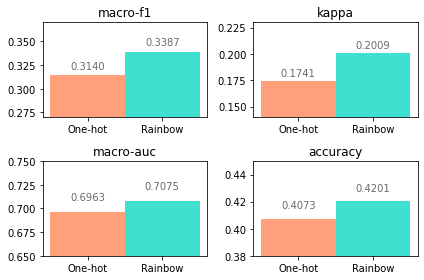

In [3]:
#hide_input
t=results.copy()
t=t.rename(columns={'macro avg_f1-score': 'macro-f1',
                       'macro avg_roc_auc':'macro-auc',
                      })
k = t[t['feature_group']=='all'].groupby(['method'])[['accuracy', 'kappa', 'macro-f1', 'macro-auc']].mean().round(4)


def make_subplot2(k, metric, x, i, j, colors, ylimits=[]):
    y = k[metric]
    rects = axs[i, j].bar(x, y, color = colors, width=1, align='center')
    axs[i, j].set_ylim(ylimits)
    axs[i, j].set_xticks(x)    
    axs[i, j].set_xticklabels(['One-hot', 'Rainbow'])
    axs[i, j].set_title(metric)
    autolabel(rects, i, j, 4)


x = np.arange(2)
fig, axs = plt.subplots(2, 2)
colors = ['lightsalmon', 'turquoise']
make_subplot2(k, 'macro-f1', x, 0, 0, colors, [0.27,0.37])
make_subplot2(k, 'kappa', x, 0, 1, colors, [0.14, 0.23])
make_subplot2(k, 'macro-auc', x, 1, 0, colors, [0.65, 0.75])
make_subplot2(k, 'accuracy', x, 1, 1, colors, [0.38, 0.45])
fig.tight_layout()
plt.show()


## Hyperparameters

The following plots show dynamic of metrics depending on every hyperparameter keeping other hyperparameters constant. These plots also clearly demonstrate the superiority of Rainbow method for every hyperparameter and every metric.

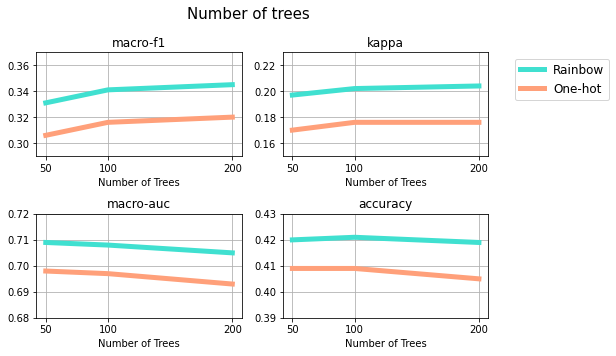

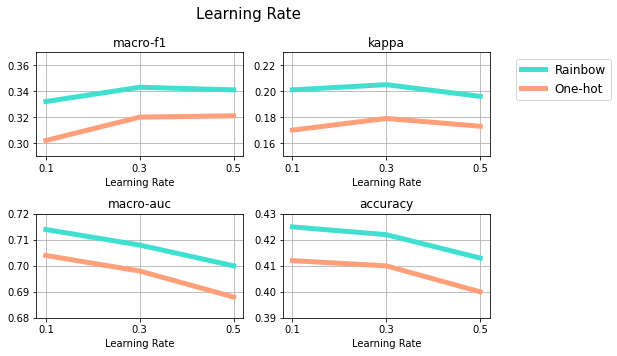

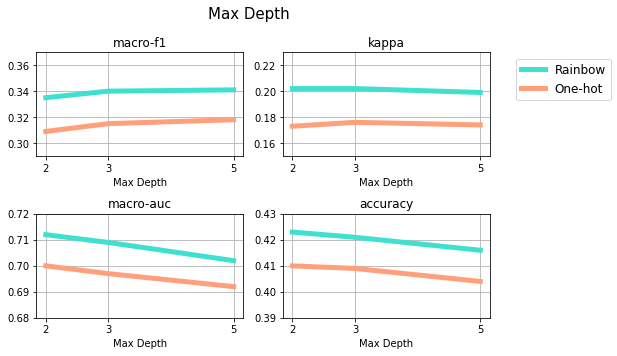

In [4]:
#hide_input
def make_subplot3(t, i, j, feature_group, hyperparameter, hyperparameter_name, metric, 
                  ylimit_bottom, ylimit_top, xticks_list):
    k1 = pd.DataFrame(t[t['feature_group']==feature_group][t['method']=='Rainbow'].groupby(
        hyperparameter)[metric].mean().round(3))
    k2 = pd.DataFrame(t[t['feature_group']==feature_group][t['method']=='One-hot'].groupby(
        hyperparameter)[metric].mean().round(3))
    ax = axs[i,j]
    k1[metric].plot(ax=ax, label = 'Rainbow', color=colors[1], linewidth=5)
    k2[metric].plot(ax=ax, label = 'One-hot', color = colors[0], linewidth=5)
    ax.set_ylim(ylimit_bottom, ylimit_top)
    ax.set_xticks(xticks_list)
    ax.grid()
    ax.set_xlabel(hyperparameter_name)
    ax.set_title(metric)



fig, axs = plt.subplots(2, 2, figsize = (7,5))
make_subplot3(t, 0, 0, 'all', 'n_trees', 'Number of Trees', 'macro-f1', 0.29, 0.37, [50, 100 ,200])
make_subplot3(t, 0, 1, 'all', 'n_trees', 'Number of Trees', 'kappa', 0.15, 0.23, [50, 100 ,200])
make_subplot3(t, 1, 0, 'all', 'n_trees', 'Number of Trees', 'macro-auc', 0.68, 0.72, [50, 100 ,200])
make_subplot3(t, 1, 1, 'all', 'n_trees', 'Number of Trees', 'accuracy', 0.39, 0.43, [50, 100 ,200])
fig.suptitle('Number of trees', fontsize=15)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.1, 2.55), loc='upper left', prop={'size': 12})
plt.show()

fig, axs = plt.subplots(2, 2, figsize = (7,5))
make_subplot3(t, 0, 0, 'all', 'eta', 'Learning Rate', 'macro-f1', 0.29, 0.37, [0.1, 0.3 ,0.5])
make_subplot3(t, 0, 1, 'all', 'eta', 'Learning Rate', 'kappa', 0.15, 0.23, [0.1, 0.3 ,0.5])
make_subplot3(t, 1, 0, 'all', 'eta', 'Learning Rate', 'macro-auc', 0.68, 0.72, [0.1, 0.3 ,0.5])
make_subplot3(t, 1, 1, 'all', 'eta', 'Learning Rate', 'accuracy', 0.39, 0.43, [0.1, 0.3 ,0.5])
fig.suptitle('Learning Rate', fontsize=15)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.1, 2.55), loc='upper left', prop={'size': 12})
plt.show()

fig, axs = plt.subplots(2, 2, figsize = (7,5))
make_subplot3(t, 0, 0, 'all',  'max_depth', 'Max Depth', 'macro-f1', 0.29, 0.37, [2, 3 ,5])
make_subplot3(t, 0, 1, 'all',  'max_depth', 'Max Depth', 'kappa', 0.15, 0.23, [2, 3 ,5])
make_subplot3(t, 1, 0, 'all',  'max_depth', 'Max Depth', 'macro-auc', 0.68, 0.72, [2, 3 ,5])
make_subplot3(t, 1, 1, 'all',  'max_depth', 'Max Depth', 'accuracy', 0.39, 0.43, [2, 3 ,5])
fig.suptitle('Max Depth', fontsize=15)
fig.tight_layout()
plt.legend(bbox_to_anchor=(1.1, 2.55), loc='upper left', prop={'size': 12})
plt.show()


## Runtime

Next, let's compare the runtime for each method.
```
One-hot: 66.074 s
Rainbow:  7.444 s
 ```
Average time to run a single rainbow model is **9 times faster** that of the single One-hot model!
So, in addition to a substantial increase in model performance metrics, Rainbow method can also save data scientists huge amount of time.

In [5]:
#hide 
pd.DataFrame(t[t['feature_group']=='all'].groupby(['method'])['total_time'].mean().round(3))

,total_time
method,
One-hot,66.074
Rainbow,7.444


## Interval, Ordinal, and Nominal

Next, we ran the models that covered the bundles of interval, ordinal, and nominal features separately. Below are the results.

In [6]:
#hide_input
u = t[t['feature_group']!='all'].groupby(['feature_group','method'])[['macro-f1', 'kappa', 'macro-auc', 'accuracy']].mean().round(4)
u = u.reindex([('interval', 'One-hot'), ('interval', 'Rainbow'),  ('ordinal', 'One-hot'), ('ordinal', 'Rainbow'),
              ('nominal', 'One-hot'), ('nominal', 'Rainbow')])
u.index.set_names(['feature group', 'method'], inplace=True)

u

macro-f1   kappa  macro-auc  accuracy
feature group method                                        
interval      One-hot    0.2965  0.1563     0.6849    0.4003
              Rainbow    0.3275  0.1894     0.7040    0.4149
ordinal       One-hot    0.2362  0.1113     0.6338    0.3784
              Rainbow    0.2500  0.1247     0.6385    0.3827
nominal       One-hot    0.2916  0.1542     0.6783    0.3938
              Rainbow    0.2940  0.1544     0.6729    0.3915

These results demonstrate again that Rainbow is preferred to One-hot. As expected, interval and ordinal features gain the most from Rainbow encoding, while nominal variables - less so.

## Feature Selection

Finally, to make a comparison more fair in terms of dimensionality, we picked top 10, top 50, and top 100 features from each feature set - Rainbow and One-hot. We used feature importance attribute of the XGBoost model and aggregated feature importance scores for 4 cross validation folds on the best hyperparameter set for each encoding type. Below are the results.

In [7]:
#hide_input

w = table1[['macro-f1', 'kappa', 'macro-auc', 'accuracy']].reset_index().replace({'one_hot': 'One-hot', 'rainbow': 'Rainbow'})
w = w.set_index(['Num_features', 'method'])
w.index.set_names(['number of features', 'method'], inplace=True)
w

macro-f1   kappa  macro-auc  accuracy
number of features method                                        
10                 One-hot    0.2685  0.1505     0.6778    0.3945
                   Rainbow    0.3273  0.1898     0.7010    0.4122
50                 One-hot    0.3342  0.1975     0.7040    0.4180
                   Rainbow    0.3428  0.2070     0.7092    0.4240
100                One-hot    0.3333  0.1992     0.7102    0.4205
                   Rainbow    0.3477  0.2105     0.7130    0.4245

Every single metric is considerably higher for the Rainbow method, especially with the lower number of selected features.
As mentioned in Part 1, rainbow encoding with 50 features is even better than One-hot with 100 features as shown by macro-f1, kappa, and accuracy. Also, note the drop from 50 to 10 features in One-hot versus rainbow - macro-f1 looses 0.0657 points with One-hot compared to only 0.0155 points with Rainbow. 

In [8]:
#hide

#import numpy as np
#np.log(table1[1::2]).diff().iloc[1]/np.log(table1[::2]).diff().iloc[1]

## Conclusion

As we illustrated above, the Rainbow method is an elegant and simple way to encode categorical variables, that will significantly reduce data dimensionality without losing any part of valuable signal; that will likely cause substantial improvements in model performance metrics (or, at the very least, will not cause any reductions in metrics); and that will save great amount of time for modelers.

Finally, we should note that this article just opens the conversation about the Rainbow method, and by no means exhausts the topic. In the potential future investigations, we could explore some other aspects. To name a few: binary and continuous target variables; comparison with other dimensionality reduction methods, such as PCA; missing values and how they fit the Rainbow framework; limits and implications of combining seemingly unrelated features into a single Rainbow. We hope to open the gate for further questions and feedback on this method.

# The Rainbow Method Part III. Conditional Mathematical Foundation

## Framework

Aside from reducing number of variables which was our main goal, we would also like to understand why do rainbows produce better results.

We wouldn't completely satisfy Einstein here, but base our foundation on assumption that pruning of the trees that maximize unregularized log-loss producing supperior values.  In fact regulariation of trees, pruning of trees and various early stopping rules are all trying to achieve the same goal, which is often summarized in "avoid overfit", yet let us examine what that really means in our case by case basis. 


Imagine you have K categories for each the optimal values to be added to the nodes are 1, 2, ..., K in some order not necessarily random.  If that was the case both on-hot encoding and rainbow method would require K-1 comparisons.  We have a tie.  That would be the case where all categories should be distinquished with different values at the end-nodes, which is rarely the case. 

To make things simple lets now assume we have 4 features and the optimal values at the end nodes are 1, 1.01, 2, 2.01  Assume further that $\epsilon$ 0.01 is low enough so that the first and second pair of of categories should not be distinguished (or the nodes that distinguished should be pruned).  

That is the whole definition of "avoid overfit", the point here is that at some point signal to uncertainty ratio is to low to make a distinction and that is why xgboost has at least 7 hyperparameters that should help in not distinquishing these pairs: max_depth, gamma, min_child_weight, lambda, alpha, min_split_loss, max_leaves

Definitions of these hyperparameters can be found here https://xgboost.readthedocs.io/en/latest/parameter.html

Now to explaination how each one of these would prevent between split of first and second categories:

## Hyperparameters that help to avoid overfit.

Taking the above 1, 1.01, 2, 2.01 example let us look at how each of these 7 hyp

1. max_depth: disallows too many splits so that on each split only best splits would be chosen, so given your max_depth<K-2, you would not get to split the first and second category into different branches (those a next tree might).

2. gamma, if this one is $<0.01$, it would not split as the difference is smaller than gamma.

3. min_child_weight, if each category has less children that min_child_weight it would not split down to one category,

4. lambda: these will help not assign the tree that does split a very small weight

5. alpha: similar as lambda

6. min_split_loss: similar to gamma except it would truncate later

7. max_leaves: similar to max_depth

## Mathematical analysis: How exactly does rainbow help?

Below we would show that rainbow always outperforms One-hot in best, average and worst case scenarios!  The discussion below applies to any tree based algorithm that relies only on order of values which include: xgboost or any gradient boosted trees or any random forest.

We first demonstrate this with a simple example, then we proceed with full generalization and simulation.



###  Examples

#### Simplest Example

Consider the following example:

- assume a binary classification problem, with output variable having values 0 and 1
- assume only one categorical variable
- assume exactly four categoties with values v1 < v2 < v3 < v4, say with a number of samples in each value
- assume an ideal separation will give (v1 and v2) samples score 1 and to (v3 anv v4) samples score 2, where score is some decision function used for separation (e.g. Gini, impurity, etc.)

If we want to build a single decision tree, then 
- in the case of rainbow: 
two samples will be sent to the left branch and two other samples will be sent to the right branch of the tree. (diagram)
In such a situation a natural split occurs between v2 and v3, and rainbow would need one split 

- while One-hot would need two or three splits.
(diagram)


#### Generalizing simple example.

Let's look at more general case, where the values of the categorical variable are in different order.


The number of splits would depend on the order in which these categories appear

For rainbow orders:

* 1,1,2,2 and 2,2,1,1 the number of splits would be 1; (1,1,2,2) is an example above.

* 1,2,2,1 and 2,1,1,2 the number of splits would require 2 

* and 1,2,1,2 and 2,1,2,1, the number of splits would require 3

One-hot would be similar except it would be the order in which the one-hot split happens:

* 1,1,2,2 and 2,2,1,1 the number of splits would be 2; 

* and 1,2,2,1 and 2,1,1,2 and 1,2,1,2 and 2,1,2,1 the number of splits would be 3

Note that these are not the same orders so we cannot say that rainbow better in each case as order at the top (in which categories appear in rainbow) is not the same order at the bottom (in which categories get split by one-hot). However we see that on average rainbow is better as it gives best case 1, average 2, worst case 3; while one hot gives best case 2, average $\frac 83$ and worst 3.  In fact we would see that this is true in general.


For One-hot, assume rainbow selection of the next choice.
- subsample col
- subsample rows
- not all splits considered, rather some approximation even on a single scale 
- counts of samples in each value can be highly uneven - this worse for one-hot

- assume inside one var all splits are considered, but not across all vars

### General Case: Random rainbow vs one-hot

Assume we have $K$ categories that optimally would need to be split into groups of size $G_1,G_2,...,G_g$. By size we mean number of categories out of K, not the number of samples. In simple example above $K=4$, $g=2$ and $G_1=2$ consisted of {v_1,v_2} and $G_2=2$ of {v_3,v_4}. 
Since our rainbow is random, the K categories would appear in random order, however for the purposes of computation only their corresponding group would matter and this is the order that we would always talk about when dealing with rainbow. (means that v1, v2 is same as v2, v1)

For one-hot the order that would matter is the one in which one-hot splits are made and this is also assume to be random.  This is the order that we would always refer to when talking about one-hot.  

> In reality the one-hot splits are not fully random and varies from the number of samples in each category, subsamples of columns that chosen and other hyperparameters.  That can have both negative and positive effect on one-hot but will make analysis much more difficult.

While the orders that matter for rainbow and one-hot are not the same it helps to couple them to make comparisons.


It is time to compute best, average and worst cases. (Let's compare)

#### Best case: One-hot
We want to make that the biggest groups won't be split.

In best case one-hot would require $K - G_{max}$ splits, where $G_{max} = max_i G_i$ is the maximum of $G_i$. The best case $K - G_{max}$ is obtained when each group except the largest one gets one split per category and the remaining largest group has the same answer so doesn't require any additional splits.  To prove that one cannot do better observe that if we do not make a split for two categories in distinct groups than there is no way to distinguish the values in these two categories.

#### Best case: Random Rainbow

In best case one-hot rainbow would require $g-1$ splits


which happens when groups are together and it simply splits at $g-1$ points to separate $g$ groups.  One cannot do better as if there is no split in between two groups there is 





no way to distinquish them.

Clearly  $$K - G_{max}=(\sum_{i=1}^g G_i)-G_{max}=(\sum_{i!=max} G_i) \geq (\sum_{i!=max} 1) = g-1$$ and hence rainbow is better in best case.

#### Average Case: One-hot

>Note: From the same logic as presented in best case follows that:
> 1. the number of splits that one-hot would need is the number $N$ of categories that are chosen before remaining ones are in one group.
> 2. the number of splits that rainbow need would always be $D$, number of consequitive pairs in rainbow order that are in distinct groups.
> In the best case N = K- Gmax, D=g-1. 

It is easiest to compute probability that $N = K-R$ for $R$ ranging from $1$ to $K$, where R representing the size of the last group in the order (so if the order in which one-hot variable corresponding to categories are chosen is for example 112233222, the R=3, since the last group 222 is of size 3).

\begin{align}
\mathbb E[N] &= \mathbb E[K-R] = K- \mathbb E[R] = K - \sum_{j=1}^{\infty} \mathbb P[R \geq j] =K- \sum_{j=1}^K \frac{\sum_i \frac{G_i!}{(G_i-j)!}} {\frac{K!}{(K-j)!}} = (K-1) - \sum_{j=2}^K \frac{\sum_i \frac{G_i!}{(G_i-j)!}} {\frac{K!}{(K-j)!}}\\
\end{align}


#### Average Case: Rainbow 

For rainbow the average case is $\mathbb E[D]$ where $D$ is number of consequitive pairs in rainbow order that are in distinct groups.

\begin{align}
\mathbb E[D] &= (K - 1) \cdot (1-\frac{ \sum_i G_i \cdot (G_i-1)} {K(K-1)}) \notag \\
             &= (K-1)-\frac{ \sum G_i \cdot (G_i-1)} {K} \notag
\end{align}

An easy way to see that this value is larger, is the stochastic coupling, since both $N$ and $D$ can be obtained as starting from $K$ and subtracting $-1$ for each consequitive pair in the same group; except in case of $N$ all these pairs have to be in string at the end.  Due to this restriction $N$ is always larger.

#### Worst Case: One-hot

Worst case for one-hot is $K-1$ when one goes through all but one category to get to one group remaining.

#### Worst Case: Rainbow

In this case it is $\min( (K - 1), 2 \cdot (K-G_{max}))$ as we can only get upto two splits per each category not in the largest group. Clearly this is also less than or equal to one-hot.


Less splits is the main argument,
less splits means less time and comput resources. How this mean less overfit?
Less time and less work means work if more effective.

### Simulation

We also present a simulation for a few examples.

,12,112,1112,1122,11112,11122,111222,11123,11223,112233,11223344,111222333,1111122233,1111111122,1111111123
One-hot Best Case,1.0,1.00,1.00,2.00,1.00,2.0,3.00,2.00,3.0,4.0,6.00,6.00,5.00,2.00,2.00
Rainbow Best Case,1.0,1.00,1.00,1.00,1.00,1.0,1.00,2.00,2.0,2.0,3.00,2.00,2.00,1.00,2.00
One-hot Average Case,1.0,1.67,2.25,2.67,2.81,3.5,4.51,3.60,3.8,4.8,6.85,7.71,8.57,7.09,7.15
Rainbow Average Case,1.0,1.33,1.50,2.01,1.60,2.4,3.00,2.79,3.2,4.0,5.99,5.99,6.20,3.20,3.40
One-hot Worst Case,1.0,2.00,3.00,3.00,4.00,4.0,5.00,4.00,4.0,5.0,7.00,8.00,9.00,9.00,9.00
Rainbow Worst Case,1.0,2.00,2.00,3.00,2.00,4.0,5.00,4.00,4.0,5.0,7.00,8.00,9.00,4.00,4.00


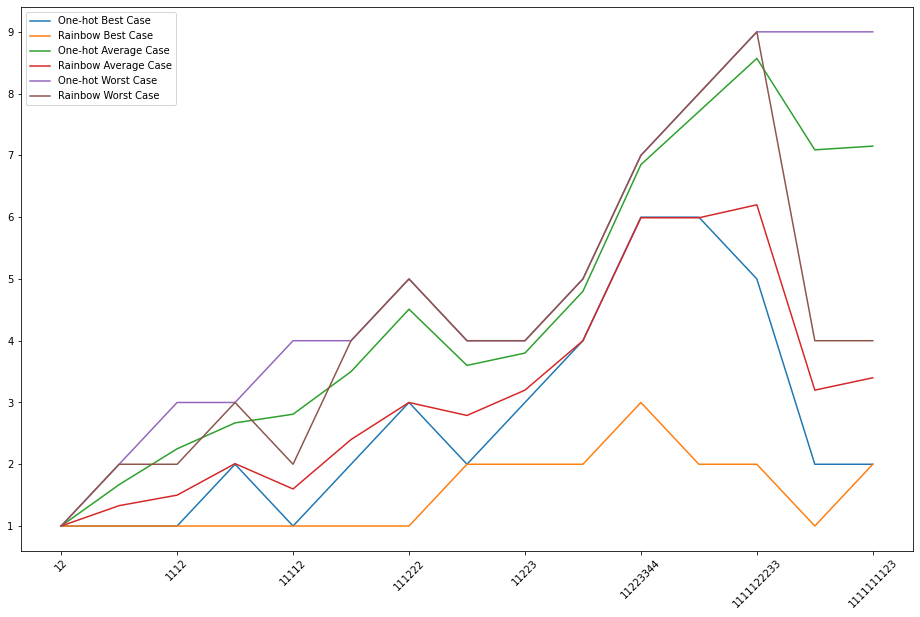

In [12]:
#collapse_input

import pandas as pd
from collections import Counter
import numpy as np

s='12,112,1112,1122,11112,11122,111222,11123,11223,112233,11223344,111222333,1111122233,1111111122,1111111123'
#s+=','+('1'*10+'2'*10)+','+('1'*20+'2'*20)
cc=examples=s.split(',')
examples=[list(i) for i in examples]

# number of splits in each scenario
o_best = [len(e)-max(Counter(e).values()) for e in examples]
r_best = [len(Counter(e))-1 for e in examples]
o_worst = [len(e)-1 for e in examples]
r_worst = [min(len(e)-1,2*(len(e)-max(Counter(e).values()))) for e in examples]


o_ave = []
r_ave = []
n_samples = 40000
# to have two precision digits
for e in examples:
    # o_sum and r_sum is the sum of number of splits over all samples
    # we want to get average n of splits given various scenarios (avg over samples)
    o_sum = r_sum = 0
    for i in range(n_samples):
        p = np.random.permutation(e) #[::-1] omiting as same thing but to indicate we count from end for one-how order
        o_res = r_res = len(e)-1
        for i in range(len(p)-1):
            if p[i]==p[i+1]:
                r_res -=1
        for i in range(len(p)-1):
            if p[i]==p[i+1]:
                o_res -=1
            else:
                break
        o_sum += o_res
        r_sum += r_res
    o_ave += [o_sum/n_samples]
    r_ave += [r_sum/n_samples]

ii = 'o_best,r_best,o_ave,r_ave,o_worst,r_worst'.replace('o_','One-hot ').replace('r_','Rainbow ')
ii = ii.replace('ave','Average').replace('best','Best').replace('worst','Worst')
ii = ii.split(',')
ii = [i+' Case' for i in ii]
rainbow_vs_onehot=pd.DataFrame([o_best,r_best,o_ave,r_ave,o_worst,r_worst],columns=cc,index=ii).round(2)
rainbow_vs_onehot.T.plot(rot=45,figsize=(16,10))
rainbow_vs_onehot

### Conclusion

As we saw above in all cases even random rainbow wins against one-hot. 

### Bonus: How many random rainbows do you need to outperform best-case One-hot?

Let's ask one last question that does not pose theoretical significance.
How many random rainbows would it take to outperform best-case one-hot?

Let us call this number of rainbows $R$ and assume it is not too large, then corresponding $D$ can on average be  
\begin{align}
\mathbb E[D] & = (K - 1) * (1-\frac{ \sum_i G_i*(G_i-1)} {K(K-1)})^R \notag\\
             & \approx (K-1)- R* \frac{ \sum G_i*(G_i-1)} {K} \tag{4}
\end{align}

So from (1) we get that.

$$\mathbb E[D] \leq K-G_{max}$$
if we let $R$ be greater than $\frac{G_{max}}{G_i}$ for all $i$ or in other words if:
$$ R \geq \frac{G_{max}}{G_{min}} $$
This is of course less than $G_{max}$.  Similar computatoin can also show that it also has to be less than $g$, but then from $g*G_{max} \leq K$ we can show that $R \leq \sqrt{K}$.  In fact with a bit more detailed calculation one can show 
$R \lessapprox \frac {\sqrt{K}}{2}$ as $K$ gets larger and this actually would imply that $R$ is not too large in the approximation we used above.

> Hence we showed that single perfect rainbow outperforms, $K$ One-hot encoding and that $\frac{\sqrt{K}}{2}$ random rainbows would outperform $K$ One-hot encodings.

#  Bibliography and References and Technical Details

## References

While the topic of One-hot and binary-One-hot encoding has been touched by many authors:

* https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159
* https://towardsdatascience.com/stop-One-hot-encoding-your-categorical-variables-bbb0fba89809

The approach presented here is rarely used in industry or academia, while has shown superior results and by definition creates less features.

In [10]:
#hide
## Basic Postprocessing

# Before proceeding with models, we applied basic feature selection to each feature set:
# * Dropped variables with all values missing
# * No imputations was done – missingness is handled by XGBoost (see [XGBoost is not black magic](https://towardsdatascience.com/xgboost-is-not-black-magic-56ca013144b4))
# * Droped variables with variance being exactly 0
# * Dropped perfect duplicates
# * Dropped perfect rank duplicates

# These procedures reduced our Rainbow feature set and One-hot feauture set to **183** and **2095** respectively.
# Thus, we ran 3 max_depth * 3 eta * 3 n_estimators * 4 folds * 2 encoding methods = 216 models. 